In [1]:
import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: False


In [ ]:
def normalization(df, columns, mode='z'):
    if mode == 'm' :
        for colname in columns:
            df[colname] = (df[colname] - df[colname].min())/(df[colname].max()-df[colname].min())
        return df
    if mode == 'z' :
        for colname in columns:
            df[colname] = (df[colname] - df[colname].mean())/df[colname].std()
        return df

# 데이터 업로드

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
import os as os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import scipy as sp
from scipy.special import boxcox1p
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import warnings
warnings.filterwarnings(action='ignore')

In [35]:
# 기본 설정 읽기
import matplotlib.pyplot as plt

# size, family
print('# 설정되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

# 설정되어있는 폰트 사이즈
10.0
# 설정되어있는 폰트 글꼴
['Malgun Gothic']


In [36]:
import platform
platform.system()

'Windows'

In [37]:
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

In [38]:
os.chdir('C:/Users/82109/Desktop')

In [83]:
df = pd.read_excel('df2019.xlsx')
test = pd.read_excel('test202006.xlsx')

In [84]:
# 요일 그룹 재범주화
conditionlist = [
    (df['dow'] == '화요일') | (df['dow'] == '수요일') | (df['dow'] == '월요일'),
    (df['dow'] == '목요일') | (df['dow'] == '금요일'),
    (df['dow'] == '토요일') | (df['dow'] == '일요일')]
choicelist = ['월화수','목금','토일']
df['group_dow2'] = np.select(conditionlist, choicelist, default='Not Specified')

In [85]:
# 상품군별 빈도수 대비 판매량
sales_group_count = df[['sales','group']]
sales_group_count.set_index('group',inplace = True)
sales_group_count['count'] = df['group'].value_counts()
sales_group_count['sales_group_count'] = sales_group_count['sales'] / sales_group_count['count']
sales_group_count.reset_index(inplace = True)
df['sales_group_count'] = sales_group_count['sales_group_count']


# 시간대별 빈도수 대비 판매량
sales_hour_count = df[['sales','hour']]
sales_hour_count.set_index('hour',inplace = True)
sales_hour_count['count'] = df['hour'].value_counts()
sales_hour_count['sales_hour_count'] = sales_hour_count['sales'] / sales_hour_count['count']
sales_hour_count.reset_index(inplace = True)
df['sales_hour_count'] = sales_hour_count['sales_hour_count']


# 요일별 빈도수 대비 판매량
sales_dow_count = df[['sales','dow']]
sales_dow_count.set_index('dow',inplace = True)
sales_dow_count['count'] = df['dow'].value_counts()
sales_dow_count['sales_dow_count'] = sales_dow_count['sales'] / sales_dow_count['count']
sales_dow_count.reset_index(inplace = True)
df['sales_dow_count'] = sales_dow_count['sales_dow_count']


# 시간대별 빈도수 대비 판매량
sales_day_night_count = df[['sales','day_night']]
sales_day_night_count.set_index('day_night',inplace = True)
sales_day_night_count['count'] = df['day_night'].value_counts()
sales_day_night_count['sales_day_night_count'] = sales_day_night_count['sales'] / sales_day_night_count['count']
sales_day_night_count.reset_index(inplace = True)
df['sales_day_night_count'] = sales_day_night_count['sales_day_night_count']


# 시간대별 빈도수 대비 판매량2
sales_day_night2_count = df[['sales','day_night2']]
sales_day_night2_count.set_index('day_night2',inplace = True)
sales_day_night2_count['count'] = df['day_night2'].value_counts()
sales_day_night2_count['sales_day_night2_count'] = sales_day_night2_count['sales'] / sales_day_night2_count['count']
sales_day_night2_count.reset_index(inplace = True)
df['sales_day_night2_count'] = sales_day_night2_count['sales_day_night2_count']


# 그룹요일별 빈도수 대비 판매량
sales_group_dow_count = df[['sales','group_dow']]
sales_group_dow_count.set_index('group_dow',inplace = True)
sales_group_dow_count['count'] = df['group_dow'].value_counts()
sales_group_dow_count['sales_group_dow_count'] = sales_group_dow_count['sales'] / sales_group_dow_count['count']
sales_group_dow_count.reset_index(inplace = True)
df['sales_group_dow_count'] = sales_group_dow_count['sales_group_dow_count']


# 그룹요일별 빈도수 대비 판매량2
sales_group_dow2_count = df[['sales','group_dow2']]
sales_group_dow2_count.set_index('group_dow2',inplace = True)
sales_group_dow2_count['count'] = df['group_dow2'].value_counts()
sales_group_dow2_count['sales_group_dow2_count'] = sales_group_dow2_count['sales'] / sales_group_dow2_count['count']
sales_group_dow2_count.reset_index(inplace = True)
df['sales_group_dow2_count'] = sales_group_dow2_count['sales_group_dow2_count']


In [86]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2', 'sales_group_count',
       'sales_hour_count', 'sales_dow_count', 'sales_day_night_count',
       'sales_day_night2_count', 'sales_group_dow_count',
       'sales_group_dow2_count'],
      dtype='object')

In [87]:
df.head(2)

,date,exposure,mot_code,product_code,product_name,group,product_detail,brand,price,tot_price,...,hour3,hour4,group_dow2,sales_group_count,sales_hour_count,sales_dow_count,sales_day_night_count,sales_day_night2_count,sales_group_dow_count,sales_group_dow2_count
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,상의,테이트,39900,2099000,...,B,B,월화수,0.012147,0.039584,0.010158,0.005458,0.005458,0.003420,0.003437
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,상의,테이트,39900,4371000,...,B,B,월화수,0.025294,0.082430,0.021153,0.011365,0.011365,0.007121,0.007157


In [150]:
df_train = df[[ 'group',
       'product_detail', 'sales', 'hour', 'dow',
       'group_dow', 'early', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 
       'test', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'sales_group_count', 'sales_hour_count',
       'sales_dow_count', 'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'group_dow2', 'sales_group_dow2_count', 
       'search for coronavirus','exchange rate','interest rate', 'average precipitation','temperature']]

In [151]:
df_train.head(2)
# LabelEncoding : 'group', 'product_detail', 'dow', 'day_night','day_night2','group_time1' , 'group_time2' , 'hour3', 'hour4', 'group_dow2'

,group,product_detail,sales,hour,dow,group_dow,early,day_night,group_time1,group_time2,...,sales_day_night_count,sales_day_night2_count,sales_group_dow_count,group_dow2,sales_group_dow2_count,search for coronavirus,exchange rate,interest rate,average precipitation,temperature
0,의류,상의,52.606516,6,화요일,2,0,오전,B,B,...,0.005458,0.005458,0.003420,월화수,0.003437,0.01336,1118.1,1.9,0.00625,-3.7
1,의류,상의,109.548872,6,화요일,2,0,오전,B,B,...,0.011365,0.011365,0.007121,월화수,0.007157,0.01336,1118.1,1.9,0.00625,-3.7


In [152]:
# 기상요인 및 경제요인 변수의 기술통계량
df_train[['temperature','search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation']].describe()

,temperature,search for coronavirus,exchange rate,interest rate,average precipitation
count,35378.000000,35378.000000,35378.000000,35378.000000,35378.000000
mean,14.957117,0.008511,1165.630106,1.668536,3.293686
std,9.249864,0.003715,29.401236,0.171649,9.077457
min,-6.450000,0.002360,1111.600000,1.420000,0.000000
25%,6.860000,0.005900,1135.700000,1.500000,0.000000
50%,15.850000,0.007990,1170.400000,1.700000,0.062500
75%,22.890000,0.009990,1189.600000,1.850000,1.768750
max,33.080000,0.024180,1218.900000,1.900000,95.693750


In [153]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35378 entries, 0 to 35377
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   group                   35378 non-null  object 
 1   product_detail          35378 non-null  object 
 2   sales                   35378 non-null  float64
 3   hour                    35378 non-null  int64  
 4   dow                     35378 non-null  object 
 5   group_dow               35378 non-null  int64  
 6   early                   35378 non-null  int64  
 7   day_night               35378 non-null  object 
 8   group_time1             35378 non-null  object 
 9   group_time2             35378 non-null  object 
 10  group_exposure          35378 non-null  int64  
 11  detail                  35378 non-null  int64  
 12  test                    35378 non-null  int64  
 13  day_night2              35378 non-null  object 
 14  holiday                 35378 non-null

### 범주형 변수 LabelEncoding

In [154]:
le1 = LabelEncoder()

df_train['group'] = le1.fit_transform(df_train['group'])

df_train['product_detail'] = le1.fit_transform(df_train['product_detail'])

df_train['dow'] = le1.fit_transform(df_train['dow'])

df_train['group_dow2'] = le1.fit_transform(df_train['group_dow2'])

df_train['day_night'] = le1.fit_transform(df_train['day_night'])

df_train['day_night2'] = le1.fit_transform(df_train['day_night2'])

df_train['group_time1'] = le1.fit_transform(df_train['group_time1'])

df_train['group_time2'] = le1.fit_transform(df_train['group_time2'])

df_train['hour3'] = le1.fit_transform(df_train['hour3'])

df_train['hour4'] = le1.fit_transform(df_train['hour4'])

### 범주형 변수 OnehotEncoding

In [155]:
df_train['group'] = pd.get_dummies(df_train['group'])

df_train['product_detail'] = pd.get_dummies(df_train['product_detail'])

df_train['dow'] = pd.get_dummies(df_train['dow'])

df_train['group_dow2'] = pd.get_dummies(df_train['group_dow2'])

df_train['day_night'] = pd.get_dummies(df_train['day_night'])

df_train['day_night2'] = pd.get_dummies(df_train['day_night2'])

df_train['group_time1'] = pd.get_dummies(df_train['group_time1'])

df_train['group_time2'] = pd.get_dummies(df_train['group_time2'])

df_train['hour3'] = pd.get_dummies(df_train['hour3'])

df_train['hour4'] = pd.get_dummies(df_train['hour4'])

df_train['group_dow'] = pd.get_dummies(df_train['group_dow'])

df_train['hour'] = pd.get_dummies(df_train['hour'])

df_train['early'] = pd.get_dummies(df_train['early'])

df_train['group_exposure'] = pd.get_dummies(df_train['group_exposure'])

df_train['detail'] = pd.get_dummies(df_train['detail'])

df_train['holiday'] = pd.get_dummies(df_train['holiday'])

df_train['hour2'] = pd.get_dummies(df_train['hour2'])

### 연속형 변수 Minmax Scaling

In [143]:
df_train.columns

Index(['group', 'product_detail', 'sales', 'hour', 'dow', 'group_dow', 'early',
       'day_night', 'group_time1', 'group_time2', 'group_exposure', 'detail',
       'test', 'day_night2', 'holiday', 'hour2', 'hour3', 'hour4',
       'sales_group_count', 'sales_hour_count', 'sales_dow_count',
       'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'group_dow2', 'sales_group_dow2_count',
       'search for coronavirus', 'exchange rate', 'interest rate',
       'average precipitation', 'temperature'],
      dtype='object')

In [156]:
# df_train['sales'] = (df_train['sales'] - df_train['sales'].min()) / (df_train['sales'].max() - df_train['sales'].min())

df_train['temperature'] = (df_train['temperature'] - df_train['temperature'].min()) / (df_train['temperature'].max() - df_train['temperature'].min())

df_train['search for coronavirus'] = (df_train['search for coronavirus'] - df_train['search for coronavirus'].min()) / (df_train['search for coronavirus'].max() - df_train['search for coronavirus'].min())

df_train['exchange rate'] = (df_train['exchange rate'] - df_train['exchange rate'].min()) / (df_train['exchange rate'].max() - df_train['exchange rate'].min())

df_train['interest rate'] = (df_train['interest rate'] - df_train['interest rate'].min()) / (df_train['interest rate'].max() - df_train['interest rate'].min())

df_train['sales_group_count'] = (df_train['sales_group_count'] - df_train['sales_group_count'].min()) / (df_train['sales_group_count'].max() - df_train['sales_group_count'].min())

df_train['sales_hour_count'] = (df_train['sales_hour_count'] - df_train['sales_hour_count'].min()) / (df_train['sales_hour_count'].max() - df_train['sales_hour_count'].min())

df_train['sales_dow_count'] = (df_train['sales_dow_count'] - df_train['sales_dow_count'].min()) / (df_train['sales_dow_count'].max() - df_train['sales_dow_count'].min())

df_train['sales_group_dow_count'] = (df_train['sales_group_dow_count'] - df_train['sales_group_dow_count'].min()) / (df_train['sales_group_dow_count'].max() - df_train['sales_group_dow_count'].min())

df_train['sales_group_dow2_count'] = (df_train['sales_group_dow2_count'] - df_train['sales_group_dow2_count'].min()) / (df_train['sales_group_dow2_count'].max() - df_train['sales_group_dow2_count'].min())

### train / test split

In [173]:
train_idx = df_train[df_train['test']==0].index
test_idx = df_train[df_train['test']==1].index

train = df_train.loc[train_idx]
test = df_train.loc[test_idx]

train_y = train['sales']
train_X = train.drop(columns = ['sales','test'])
test_y = test['sales']
test_X = test.drop(columns = ['sales','test'])

In [174]:
print('train set dim: {}'.format(train_X.shape))
print('test set dim: {}'.format(test_X.shape))

train set dim: (22087, 29)
test set dim: (13291, 29)


### k-fold cv (XGBOOST)

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb

In [161]:
xgb_preds = []
K = 5
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [175]:
%time
for train_index, valid_index in kf.split(train):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':10, 'subsample': 0.9, 'colsample_bytree': 0.9, 
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': False}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(xgb_params, d_train,  20000,  watchlist, verbose_eval=100, early_stopping_rounds=100)
                        
    xgb_pred = xgb_model.predict(d_valid)
    xgb_preds.append(list(xgb_pred))

[16:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:282.65906	valid-mae:280.59338
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[50]	train-mae:268.93478	valid-mae:266.94330
[100]	train-mae:255.87936	valid-mae:253.97188
[150]	train-mae:243.45847	valid-mae:241.63209
[200]	train-mae:231.63663	valid-mae:229.88434
[250]	train-mae:220.39348	valid-mae:218.71413
[300]	train-mae:209.69

[8550]	train-mae:0.90216	valid-mae:1.92165
[8600]	train-mae:0.89891	valid-mae:1.91944
[8650]	train-mae:0.89564	valid-mae:1.91711
[8700]	train-mae:0.89265	valid-mae:1.91497
[8750]	train-mae:0.88985	valid-mae:1.91302
[8800]	train-mae:0.88710	valid-mae:1.91116
[8850]	train-mae:0.88460	valid-mae:1.90959
[8900]	train-mae:0.88202	valid-mae:1.90769
[8950]	train-mae:0.87951	valid-mae:1.90590
[9000]	train-mae:0.87682	valid-mae:1.90400
[9050]	train-mae:0.87409	valid-mae:1.90198
[9100]	train-mae:0.87157	valid-mae:1.90006
[9150]	train-mae:0.86900	valid-mae:1.89809
[9200]	train-mae:0.86667	valid-mae:1.89641
[9250]	train-mae:0.86443	valid-mae:1.89479
[9300]	train-mae:0.86221	valid-mae:1.89311
[9350]	train-mae:0.86014	valid-mae:1.89164
[9400]	train-mae:0.85810	valid-mae:1.89020
[9450]	train-mae:0.85576	valid-mae:1.88841
[9500]	train-mae:0.85366	valid-mae:1.88672
[9550]	train-mae:0.85149	valid-mae:1.88507
[9600]	train-mae:0.84944	valid-mae:1.88346
[9650]	train-mae:0.84716	valid-mae:1.88151
[9700]	trai

[17900]	train-mae:0.56447	valid-mae:1.64208
[17950]	train-mae:0.56372	valid-mae:1.64158
[18000]	train-mae:0.56290	valid-mae:1.64095
[18050]	train-mae:0.56212	valid-mae:1.64041
[18100]	train-mae:0.56094	valid-mae:1.63935
[18150]	train-mae:0.55991	valid-mae:1.63851
[18200]	train-mae:0.55897	valid-mae:1.63780
[18250]	train-mae:0.55822	valid-mae:1.63731
[18300]	train-mae:0.55736	valid-mae:1.63665
[18350]	train-mae:0.55640	valid-mae:1.63589
[18400]	train-mae:0.55540	valid-mae:1.63510
[18450]	train-mae:0.55443	valid-mae:1.63437
[18500]	train-mae:0.55356	valid-mae:1.63366
[18550]	train-mae:0.55281	valid-mae:1.63310
[18600]	train-mae:0.55196	valid-mae:1.63251
[18650]	train-mae:0.55094	valid-mae:1.63161
[18700]	train-mae:0.55005	valid-mae:1.63095
[18750]	train-mae:0.54908	valid-mae:1.63020
[18800]	train-mae:0.54820	valid-mae:1.62956
[18850]	train-mae:0.54744	valid-mae:1.62904
[18900]	train-mae:0.54651	valid-mae:1.62831
[18950]	train-mae:0.54559	valid-mae:1.62753
[19000]	train-mae:0.54470	valid-

[6150]	train-mae:1.24718	valid-mae:1.99779
[6200]	train-mae:1.22834	valid-mae:1.98381
[6250]	train-mae:1.21023	valid-mae:1.97048
[6300]	train-mae:1.19317	valid-mae:1.95790
[6350]	train-mae:1.17714	valid-mae:1.94631
[6400]	train-mae:1.16189	valid-mae:1.93511
[6450]	train-mae:1.14739	valid-mae:1.92457
[6500]	train-mae:1.13346	valid-mae:1.91450
[6550]	train-mae:1.12072	valid-mae:1.90522
[6600]	train-mae:1.10855	valid-mae:1.89644
[6650]	train-mae:1.09704	valid-mae:1.88797
[6700]	train-mae:1.08602	valid-mae:1.88005
[6750]	train-mae:1.07533	valid-mae:1.87260
[6800]	train-mae:1.06498	valid-mae:1.86532
[6850]	train-mae:1.05504	valid-mae:1.85821
[6900]	train-mae:1.04588	valid-mae:1.85170
[6950]	train-mae:1.03701	valid-mae:1.84538
[7000]	train-mae:1.02848	valid-mae:1.83945
[7050]	train-mae:1.02072	valid-mae:1.83390
[7100]	train-mae:1.01298	valid-mae:1.82867
[7150]	train-mae:1.00596	valid-mae:1.82387
[7200]	train-mae:0.99871	valid-mae:1.81909
[7250]	train-mae:0.99149	valid-mae:1.81428
[7300]	trai

[15550]	train-mae:0.58862	valid-mae:1.50923
[15600]	train-mae:0.58740	valid-mae:1.50835
[15650]	train-mae:0.58627	valid-mae:1.50748
[15700]	train-mae:0.58513	valid-mae:1.50657
[15750]	train-mae:0.58387	valid-mae:1.50560
[15800]	train-mae:0.58267	valid-mae:1.50464
[15850]	train-mae:0.58151	valid-mae:1.50372
[15900]	train-mae:0.58014	valid-mae:1.50261
[15950]	train-mae:0.57908	valid-mae:1.50174
[16000]	train-mae:0.57800	valid-mae:1.50083
[16050]	train-mae:0.57699	valid-mae:1.50002
[16100]	train-mae:0.57564	valid-mae:1.49879
[16150]	train-mae:0.57450	valid-mae:1.49782
[16200]	train-mae:0.57328	valid-mae:1.49673
[16250]	train-mae:0.57211	valid-mae:1.49582
[16300]	train-mae:0.57098	valid-mae:1.49491
[16350]	train-mae:0.56993	valid-mae:1.49416
[16400]	train-mae:0.56896	valid-mae:1.49344
[16450]	train-mae:0.56795	valid-mae:1.49263
[16500]	train-mae:0.56675	valid-mae:1.49158
[16550]	train-mae:0.56589	valid-mae:1.49099
[16600]	train-mae:0.56480	valid-mae:1.49016
[16650]	train-mae:0.56381	valid-

[3750]	train-mae:6.90408	valid-mae:7.25303
[3800]	train-mae:6.57887	valid-mae:6.94589
[3850]	train-mae:6.26969	valid-mae:6.65493
[3900]	train-mae:5.97560	valid-mae:6.38382
[3950]	train-mae:5.69595	valid-mae:6.12812
[4000]	train-mae:5.43034	valid-mae:5.88896
[4050]	train-mae:5.17810	valid-mae:5.66410
[4100]	train-mae:4.93839	valid-mae:5.45234
[4150]	train-mae:4.71071	valid-mae:5.25232
[4200]	train-mae:4.49491	valid-mae:5.06437
[4250]	train-mae:4.29060	valid-mae:4.88735
[4300]	train-mae:4.09661	valid-mae:4.72020
[4350]	train-mae:3.91310	valid-mae:4.56271
[4400]	train-mae:3.73930	valid-mae:4.41430
[4450]	train-mae:3.57511	valid-mae:4.27617
[4500]	train-mae:3.41993	valid-mae:4.14614
[4550]	train-mae:3.27342	valid-mae:4.02440
[4600]	train-mae:3.13492	valid-mae:3.91032
[4650]	train-mae:3.00375	valid-mae:3.80332
[4700]	train-mae:2.87955	valid-mae:3.70274
[4750]	train-mae:2.76243	valid-mae:3.60912
[4800]	train-mae:2.65181	valid-mae:3.52115
[4850]	train-mae:2.54729	valid-mae:3.43901
[4900]	trai

[13250]	train-mae:0.65265	valid-mae:2.22577
[13300]	train-mae:0.65138	valid-mae:2.22488
[13350]	train-mae:0.65018	valid-mae:2.22400
[13400]	train-mae:0.64892	valid-mae:2.22311
[13450]	train-mae:0.64766	valid-mae:2.22221
[13500]	train-mae:0.64644	valid-mae:2.22133
[13550]	train-mae:0.64522	valid-mae:2.22045
[13600]	train-mae:0.64385	valid-mae:2.21944
[13650]	train-mae:0.64245	valid-mae:2.21841
[13700]	train-mae:0.64109	valid-mae:2.21734
[13750]	train-mae:0.63994	valid-mae:2.21649
[13800]	train-mae:0.63862	valid-mae:2.21541
[13850]	train-mae:0.63717	valid-mae:2.21431
[13900]	train-mae:0.63614	valid-mae:2.21366
[13950]	train-mae:0.63517	valid-mae:2.21307
[14000]	train-mae:0.63399	valid-mae:2.21232
[14050]	train-mae:0.63245	valid-mae:2.21109
[14100]	train-mae:0.63078	valid-mae:2.20969
[14150]	train-mae:0.62941	valid-mae:2.20866
[14200]	train-mae:0.62809	valid-mae:2.20762
[14250]	train-mae:0.62678	valid-mae:2.20671
[14300]	train-mae:0.62554	valid-mae:2.20583
[14350]	train-mae:0.62423	valid-

[1500]	train-mae:63.43642	valid-mae:63.81478
[1550]	train-mae:60.36338	valid-mae:60.75472
[1600]	train-mae:57.43867	valid-mae:57.84256
[1650]	train-mae:54.65706	valid-mae:55.07352
[1700]	train-mae:52.01045	valid-mae:52.43890
[1750]	train-mae:49.49260	valid-mae:49.93290
[1800]	train-mae:47.09684	valid-mae:47.54853
[1850]	train-mae:44.81839	valid-mae:45.28113
[1900]	train-mae:42.65106	valid-mae:43.12431
[1950]	train-mae:40.58846	valid-mae:41.07112
[2000]	train-mae:38.62590	valid-mae:39.11745
[2050]	train-mae:36.75904	valid-mae:37.25837
[2100]	train-mae:34.98313	valid-mae:35.49033
[2150]	train-mae:33.29313	valid-mae:33.80745
[2200]	train-mae:31.68511	valid-mae:32.20630
[2250]	train-mae:30.15577	valid-mae:30.68347
[2300]	train-mae:28.70023	valid-mae:29.23430
[2350]	train-mae:27.31564	valid-mae:27.85603
[2400]	train-mae:25.99797	valid-mae:26.54418
[2450]	train-mae:24.74480	valid-mae:25.29649
[2500]	train-mae:23.55199	valid-mae:24.10923
[2550]	train-mae:22.41763	valid-mae:22.97995
[2600]	tra

[10950]	train-mae:0.69997	valid-mae:2.10890
[11000]	train-mae:0.69738	valid-mae:2.10628
[11050]	train-mae:0.69458	valid-mae:2.10354
[11100]	train-mae:0.69203	valid-mae:2.10108
[11150]	train-mae:0.68976	valid-mae:2.09903
[11200]	train-mae:0.68719	valid-mae:2.09654
[11250]	train-mae:0.68488	valid-mae:2.09423
[11300]	train-mae:0.68262	valid-mae:2.09200
[11350]	train-mae:0.68025	valid-mae:2.08973
[11400]	train-mae:0.67756	valid-mae:2.08716
[11450]	train-mae:0.67539	valid-mae:2.08499
[11500]	train-mae:0.67351	valid-mae:2.08321
[11550]	train-mae:0.67150	valid-mae:2.08137
[11600]	train-mae:0.66954	valid-mae:2.07945
[11650]	train-mae:0.66744	valid-mae:2.07742
[11700]	train-mae:0.66547	valid-mae:2.07564
[11750]	train-mae:0.66351	valid-mae:2.07378
[11800]	train-mae:0.66118	valid-mae:2.07146
[11850]	train-mae:0.65885	valid-mae:2.06929
[11900]	train-mae:0.65749	valid-mae:2.06807
[11950]	train-mae:0.65553	valid-mae:2.06626
[12000]	train-mae:0.65358	valid-mae:2.06451
[12050]	train-mae:0.65186	valid-

Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[50]	train-mae:269.16647	valid-mae:266.03296
[100]	train-mae:256.08975	valid-mae:253.12930
[150]	train-mae:243.65048	valid-mae:240.85036
[200]	train-mae:231.81671	valid-mae:229.16228
[250]	train-mae:220.56175	valid-mae:218.04849
[300]	train-mae:209.85341	valid-mae:207.46840
[350]	train-mae:199.66754	valid-mae:197.40329
[400]	train-mae:189.97292	valid-mae:187.82165
[450]	train-mae:180.75301	valid-mae:178.70747
[500]	train-mae:171.97754	valid-mae:170.03764
[550]	train-mae:163.62811	valid-mae:161.78473
[600]	train-mae:155.68391	valid-mae:153.93129
[650]	train-mae:148.12915	valid-mae:146.46782
[700]	train-mae:140.93926	valid-mae:139.36108
[750]	train-mae:134.10129	valid-mae:132.60411
[800]	train-mae:127.59402	valid-mae:126.16970
[850]	train-mae:121.40331	valid-mae:120.04874
[900]	train-mae:115.51308	valid-mae:114.22627
[950]	train-mae:109.91007	val

[9250]	train-mae:0.83142	valid-mae:2.01491
[9300]	train-mae:0.82932	valid-mae:2.01403
[9350]	train-mae:0.82738	valid-mae:2.01329
[9400]	train-mae:0.82503	valid-mae:2.01213
[9450]	train-mae:0.82283	valid-mae:2.01119
[9500]	train-mae:0.82073	valid-mae:2.01010
[9550]	train-mae:0.81859	valid-mae:2.00907
[9600]	train-mae:0.81629	valid-mae:2.00779
[9650]	train-mae:0.81427	valid-mae:2.00670
[9700]	train-mae:0.81189	valid-mae:2.00524
[9750]	train-mae:0.80959	valid-mae:2.00398
[9800]	train-mae:0.80719	valid-mae:2.00251
[9850]	train-mae:0.80508	valid-mae:2.00126
[9900]	train-mae:0.80297	valid-mae:1.99993
[9950]	train-mae:0.80051	valid-mae:1.99832
[10000]	train-mae:0.79800	valid-mae:1.99677
[10050]	train-mae:0.79577	valid-mae:1.99536
[10100]	train-mae:0.79379	valid-mae:1.99415
[10150]	train-mae:0.79148	valid-mae:1.99260
[10200]	train-mae:0.78926	valid-mae:1.99113
[10250]	train-mae:0.78735	valid-mae:1.98987
[10300]	train-mae:0.78482	valid-mae:1.98802
[10350]	train-mae:0.78256	valid-mae:1.98645
[10

[18600]	train-mae:0.52791	valid-mae:1.78706
[18650]	train-mae:0.52721	valid-mae:1.78645
[18700]	train-mae:0.52646	valid-mae:1.78584
[18750]	train-mae:0.52570	valid-mae:1.78536
[18800]	train-mae:0.52470	valid-mae:1.78449
[18850]	train-mae:0.52398	valid-mae:1.78399
[18900]	train-mae:0.52318	valid-mae:1.78336
[18950]	train-mae:0.52247	valid-mae:1.78277
[19000]	train-mae:0.52184	valid-mae:1.78234
[19050]	train-mae:0.52114	valid-mae:1.78178
[19100]	train-mae:0.52039	valid-mae:1.78120
[19150]	train-mae:0.51975	valid-mae:1.78067
[19200]	train-mae:0.51911	valid-mae:1.78016
[19250]	train-mae:0.51834	valid-mae:1.77957
[19300]	train-mae:0.51756	valid-mae:1.77893
[19350]	train-mae:0.51688	valid-mae:1.77844
[19400]	train-mae:0.51619	valid-mae:1.77792
[19450]	train-mae:0.51550	valid-mae:1.77744
[19500]	train-mae:0.51498	valid-mae:1.77706
[19550]	train-mae:0.51418	valid-mae:1.77637
[19600]	train-mae:0.51352	valid-mae:1.77588
[19650]	train-mae:0.51289	valid-mae:1.77539
[19700]	train-mae:0.51218	valid-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

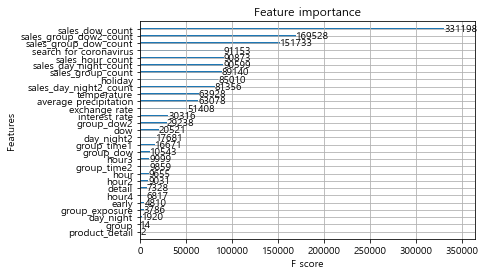

In [176]:
xgb.plot_importance(xgb_model)

In [194]:
d_test = xgb.DMatrix(test_X)
xgb_pred = xgb_model.predict(d_test)
xgb_pred

array([1215.2776  , 2200.022   , 1370.5458  , ...,   53.27073 ,
         53.91799 ,   50.909065], dtype=float32)

In [195]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE(test_y, xgb_pred)

1.21641308426534

In [ ]:
preds=[]
for i in range(len(xgb_preds[0])):
    sum=0
    for j in range(K):
        sum+=xgb_preds[j][i]
    preds.append(sum / K)

output = pd.DataFrame({'id': id_test, 'target': preds})

### k-fold CV (LGBM)